# Predicting Car Prices using KNN

In this project, we will use the K-nearest neighbors algorithm to predict car's market price using its attributes. The metric used to calculate the distance between observations is the Standard Euclidean. In this particular notebook, the validation process used is the K-fold Cross Validation Method, with 5 folds.

### Importing libraries and the prepared file

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [11]:
# Importing the prepared csv file
numeric_cars = pd.read_csv("numeric_cars.csv")
price_col = numeric_cars['price']   
train_cols = numeric_cars.drop('price', axis=1).copy()

### Modeling

In [12]:
# STANDARD MODEL
# Multivariate Model - all features
# Nearest Neighbours K = 5
# K-Fold Cross Validation K = 5

knn = KNeighborsRegressor()
cv = cross_validate(knn, train_cols, price_col, cv=5, scoring = 'neg_mean_squared_error')
rmse_all = np.sqrt(-cv['test_score'])
rmse = rmse_all.mean()
rmse

4955.1919542532805

In [13]:
# FIRST MODEL
# Univariate Model - testing all features individually
# Nearest Neighbours K = 5
# K-Fold Cross Validation K = 5
# Objective: start to analyze how good of a feature each column is.

results_1 = {}

for col in train_cols:
    knn = KNeighborsRegressor()
    cv = cross_validate(knn, train_cols[[col]], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_1[col] = rmse
    
results_series_1 = pd.Series(results_1).sort_values()
results_series_1

engine-size         4389.796782
horsepower          4504.664347
highway-mpg         4875.444934
city-mpg            4972.802501
curb-weight         5127.589070
width               5856.965140
compression-rate    6817.553416
length              7401.766907
wheel-base          8027.145563
bore                8791.497416
stroke              9312.540520
peak-rpm            9381.239354
height              9478.361941
dtype: float64

In [14]:
# SECOND MODEL
# Univariate Model - testing all features individually
# Nearest Neighbours - testing all odd numbers from 1 to 15
# K-Fold Cross Validation K = 5
# Objective: continue to analyze how good of a feature each column is.

n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

results_2 = {}
mean_results_2 = {}

for col in train_cols:
    results_col = {}
    col_values = []
    for n in n_neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        cv = cross_validate(knn, train_cols[[col]], price_col, cv=5, scoring = 'neg_mean_squared_error')
        rmse_all = np.sqrt(-cv['test_score'])
        rmse = rmse_all.mean()
        results_col[n] = rmse
        col_values.append(rmse)
    mean_results_2[col] = np.mean(col_values)
    results_2[col] = results_col
    
results_series_2 = pd.Series(results_2)
mean_results_series_2 = pd.Series(mean_results_2).sort_values()
mean_results_series_2

engine-size         4596.141500
horsepower          4694.658952
highway-mpg         5117.191258
city-mpg            5190.532603
curb-weight         5364.745026
width               5984.247439
length              7057.441979
compression-rate    7371.232748
wheel-base          7671.097618
bore                8665.348499
stroke              8963.474350
peak-rpm            9379.840376
height              9486.772718
dtype: float64

With the mean results, we get a more solid idea of how each column perform as a feature.  The graph below shows how they performed for each K number of neighbors tested out. 

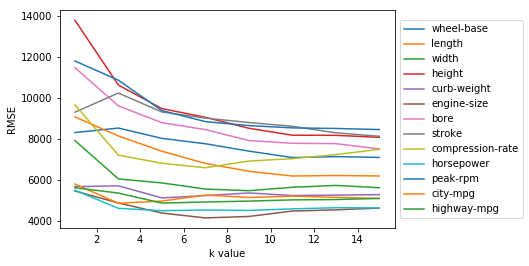

In [15]:
%matplotlib inline

for k,v in results_series_2.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(train_cols, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title('')

In [16]:
# THIRD MODEL
# Multivariate Model - testing all number of X best features
# Nearest Neighbours K = 5
# K-Fold Cross Validation K = 5
# Objective: begin to determine how many and which features to use in our multivariate model in order to get the lowest RMSE.

results_index = mean_results_series_2.index

results_3 = {}

for n in range(1, 14):
    features = []
    for i in range(0, n):
        col = results_index[i]
        features.append(col)    
    knn = KNeighborsRegressor()
    cv = cross_validate(knn, train_cols[features], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_3['{} best features'.format(n)] = rmse
    
results_series_3 = pd.Series(results_3).sort_values()
results_series_3

4 best features     3512.117865
3 best features     3587.476182
2 best features     3686.230700
6 best features     4011.336440
7 best features     4178.221121
1 best features     4389.796782
5 best features     4412.416809
8 best features     4690.721012
9 best features     4767.223058
10 best features    4888.522739
13 best features    4951.628875
12 best features    4974.465339
11 best features    4997.988714
dtype: float64

#### Important observations so far

Interpreting the results from the second and third model.

From the second model, we can see that, although the `curb-weight` variable has similar RMSE mean results in comparison to both `highway-mpg` and `city-mpg` variables, it's curve on the graph is less smoother at the beginning and there isn't a single K value in which the `curb-weight` RMSE is lower than the top 4.
In addition to this, from the second model, we have the information that using the 2, 3 or 4 best features has very similar RMSE values, those being way lower RMSE than using 5 or more.

Based on these observations, although using the 4 best features granted us the best results in the Third Model, if we test every combination of the 4 best features, we may find an even better combination.

In [17]:
# FOURTH MODEL
# Multivariate Model - testing all combinations of the 4 best features
# Nearest Neighbours - testing all odd numbers from 1 to 15
# K-Fold Cross Validation K = 5
# Objective: continue to determine how many features to use in our multivariate model in order to get the lowest RMSE.

def combinations(iterable, r):
    
    """ 
    This combination function is based on the homonym from the iteratools library.
    I modified it to return lists instead of tuples, so that I could use them in the
    cross_validate function. 
    """
    
    pool = list(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

        
b_f = results_index[0:4] #b_f are the four best features (engine-size, horsepower, highway-mpg and city-mpg) in terms of RMSE

complete_c = []
for r in range(1,5):
    c = list(combinations(b_f, r))
    complete_c += c
    

results_4 = {}
for combination in complete_c:
    knn = KNeighborsRegressor()
    cv = cross_validate(knn, train_cols[combination], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_4[str(combination)] = rmse

results_series_4 = pd.Series(results_4).sort_values()
results_series_4.head()

['engine-size', 'horsepower', 'city-mpg']                   3230.195816
['engine-size', 'horsepower', 'highway-mpg', 'city-mpg']    3512.117865
['engine-size', 'horsepower', 'highway-mpg']                3587.476182
['engine-size', 'highway-mpg']                              3650.152168
['engine-size', 'city-mpg']                                 3672.981345
dtype: float64

From the Fourth Model, we can see that actually, the best combination of the 4 best features in terms of RMSE is `engine-size`, `horsepower` and `city-mpg`, that are the first, second and forth best features individually from the second model.

In [18]:
# FIFTH MODEL
# Multivariate Model - using engine-size, horsepower and city-mpg
# Nearest Neighbours - testing all odd numbers from 1 to 15
# K-Fold Cross Validation K = 5
# Objective: test the final model.

results_5 = {}

for n in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=n)
    cv = cross_validate(knn, train_cols[['engine-size','horsepower','city-mpg']], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_5['K Value of {}'.format(n)] = rmse

results_5

{'K Value of 1': 4019.778788490677,
 'K Value of 3': 3071.599041290298,
 'K Value of 5': 3230.195815801379,
 'K Value of 7': 3601.8655365366058,
 'K Value of 9': 3948.129870256506,
 'K Value of 11': 4150.723997239938,
 'K Value of 13': 4291.885150962573,
 'K Value of 15': 4338.4775103691245}

### Conclusions

With this analysis, by using the K-fold Cross Validation method with 5 folds, we conclude that the best K Nearest Neighbors Regressor model to use takes into consideration 3 neighbors and utilizes the `engine-size`, `horsepower` and `city-mpg` columns as features. The best obtained RMSE is 3072.53, that is 38% lower than the standard KNN scikit-learn model results, and 30.55% lower than the best univariate KNN model using the standard number of neighbors (K=5).


### Next steps

Because of how small our dataset is, redoing this analysis utilizing the LOOCV (Leave One Out Cross Validation) method may be a good option, to get an even better grasp of what are the best parameters for our model.
